# 1. Project Context

## Business Problem - Forecast product demand 2 weeks ahead to optimize inventory management and reduce stockouts/overstock situations.

## Technical Challenges
- **Extreme sparsity**: 99% zero demand values in daily data
- **Temporal patterns**: Seasonal and holiday effects
- **Category diversity**: 71 different product categories with unique demand patterns
- **Forecast horizon**: 2-week ahead prediction with 1-week gap

## Solution Approach

**Data Granularity**: from Daily → Weekly aggregation predictions with category-specific models  

**Time Horizon**: Current week (T) → Target week (T+2)  


# 2. Setup & Data Loading

Import required libraries and load the preprocessed daily demand data from notebook 01.


In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from lightgbm import LGBMRegressor

# Holiday calendar library
import holidays
from datetime import datetime

# Custom utilities
from model_utils import plot_prediction_dashboard

# Configure display settings
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load preprocessed daily demand data
# Source: notebook 01 data preprocessing pipeline
data = pd.read_csv('../outputs/demand_data_pp.csv')
print("Data loaded successfully!")

# Dataset overview
print(f"Dataset size: {data.shape[0]:,} rows × {data.shape[1]} columns")
print(f"Date range: {data['order_date'].min()} to {data['order_date'].max()}")
print(f"Product categories: {data['categ'].nunique()}")
print(f"Unique products: {data['product_id'].nunique():,}")

# Display sample data
data.head()

Data loaded successfully!
Dataset size: 23,599,542 rows × 5 columns
Date range: 2016-09-04 to 2018-09-03
Product categories: 71
Unique products: 32,328


,order_date,product_id,categ,price,demand
0,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,1.0
1,2016-09-05,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
2,2016-09-06,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
3,2016-09-07,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
4,2016-09-08,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0


# 3. Data Aggregation Strategy

Transform daily demand data to weekly aggregation to reduce sparsity while preserving temporal patterns.


## Sparsity Challenge

Daily product-level data creates extreme sparsity (99% zeros) due to:
- Many products sold infrequently
- Large product catalog with varied demand patterns  
- Natural intermittent demand patterns

**Solution**: Aggregate to weekly level to reduce sparsity while maintaining temporal structure.

In [3]:
# Convert daily data to weekly aggregation
df = data.copy()
df['order_date'] = pd.to_datetime(df['order_date'])

# Create weekly periods starting Monday
df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Aggregate to weekly level by product and category
weekly_df = df.groupby(['product_id', 'categ', 'week']).agg({
    'demand': 'sum',      # Total weekly demand per product
    'price': 'mean',      # Average weekly price per product
}).reset_index()

print(f"Aggregation complete: {len(df):,} daily rows → {len(weekly_df):,} weekly rows")
weekly_df.head()

Aggregation complete: 23,599,542 daily rows → 3,426,768 weekly rows


,product_id,categ,week,demand,price
0,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-08-29,0.0,101.65
1,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-05,0.0,101.65
2,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-12,0.0,101.65
3,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-19,0.0,101.65
4,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-26,0.0,101.65


## Feature Categories

Our feature engineering approach creates several types of predictive features:

- **Temporal Features**: Historical demand patterns (lags, rolling averages)
- **Price Features**: Price levels and changes over time  
- **Calendar Features**: Seasonality, holidays, and special periods
- **Category Features**: Category-specific demand patterns and trends


### Temporal Features

Historical demand patterns to capture trend and seasonality information.


In [4]:
# Lag features: Historical demand patterns
# Sort by product and time to ensure consistent lag calculation
print("Creating essential temporal features...")

# Sort by product and time 
weekly_df = weekly_df.sort_values(['product_id', 'week'])

# Core lag features 
weekly_df['lag_1w'] = weekly_df.groupby('product_id')['demand'].shift(1)
weekly_df['lag_2w'] = weekly_df.groupby('product_id')['demand'].shift(2)

# Rolling mean, recent volatility
weekly_df['rolling_mean_4w'] = (
    weekly_df.groupby('product_id')['demand']
    .transform(lambda x: x.shift(1).rolling(window=4, min_periods=1).mean())
)
# Simple trend (works better than complex ones)
weekly_df['simple_trend'] = weekly_df.groupby('product_id')['demand'].transform(
    lambda x: x.rolling(2).mean() - x.rolling(4).mean()
)

# Fill missing values
weekly_df['lag_1w'] = weekly_df['lag_1w'].fillna(0)
weekly_df['lag_2w'] = weekly_df['lag_2w'].fillna(0)
weekly_df['rolling_mean_4w'] = weekly_df['rolling_mean_4w'].fillna(0)
weekly_df['simple_trend'] = weekly_df['simple_trend'].fillna(0) 

print("✅ Essential temporal features created")


Creating essential temporal features...
✅ Essential temporal features created


### Price Features

Price dynamics and changes that may impact demand patterns.


In [5]:
print("Creating price features...")

# Price change features: Impact of price dynamics on demand
weekly_df['price_change'] = (weekly_df.groupby('product_id')['price'].diff())

# Price change percentage for better interpretability
weekly_df['price_change_pct'] = (weekly_df.groupby('product_id')['price'].pct_change())

# Price relative to category (very powerful for demand prediction)
weekly_df['price_vs_category'] = (
    weekly_df['price'] / 
    weekly_df.groupby('categ')['price'].transform('mean')
)

# Fill missing values for price features
price_features = ['price_change', 'price_change_pct']
for col in price_features:
    weekly_df[col] = weekly_df[col].fillna(0)

print("Price features created: price_change, price_change_pct")


Creating price features...
Price features created: price_change, price_change_pct


### Calendar & Holiday Features

Seasonal patterns, holidays, and special periods that significantly impact demand patterns.


In [6]:
print("Creating essential calendar features...")

# Ensure datetime format for calendar calculations
weekly_df['week'] = pd.to_datetime(weekly_df['week'])
weekly_df['month'] = weekly_df['week'].dt.month
weekly_df['weekofyear'] = weekly_df['week'].dt.isocalendar().week

def calculate_days_to_christmas(date):
    year = date.year
    christmas_current = pd.Timestamp(f'{year}-12-25')
    christmas_next = pd.Timestamp(f'{year+1}-12-25')
    return (christmas_current - date).days if date <= christmas_current else (christmas_next - date).days

def calculate_days_from_christmas(date):
    year = date.year
    christmas_current = pd.Timestamp(f'{year}-12-25')
    christmas_prev = pd.Timestamp(f'{year-1}-12-25')
    return (date - christmas_current).days if date >= christmas_current else (date - christmas_prev).days

weekly_df['days_to_christmas'] = weekly_df['week'].apply(calculate_days_to_christmas)
weekly_df['days_from_christmas'] = weekly_df['week'].apply(calculate_days_from_christmas)

print("✅ Essential calendar features created")


Creating essential calendar features...
✅ Essential calendar features created


In [7]:

print("Creating category demand volatility...")

weekly_df['cat_demand_volatility'] = (
    weekly_df.groupby('categ')['demand']
    .transform(lambda x: x.shift(1).rolling(window=8, min_periods=1).std())
)

# Fill missing values
weekly_df['cat_demand_volatility'] = weekly_df.groupby('categ')['cat_demand_volatility'].transform(
    lambda x: x.fillna(x.mean())
)

print("✅ Category volatility feature created")

Creating category demand volatility...
✅ Category volatility feature created


In [8]:
# Simple but efficient missing value treatment
print("Checking missing values...")

# Verify missing values are handled
missing_after = weekly_df.isnull().sum().sum()
print(f"Missing values after treatment: {missing_after}")
print("✅ Missing values handled successfully!")


Checking missing values...
Missing values after treatment: 0
✅ Missing values handled successfully!


# 8. Data Inspection

Review the final engineered dataset before export to ensure all features are properly created.


In [9]:
# Display final dataset structure
print("Final dataset overview:")
print(f"Shape: {weekly_df.shape}")
print(f"Date range: {weekly_df['week'].min()} to {weekly_df['week'].max()}")
print(f"Features: {list(weekly_df.columns)}")

# Sample of engineered features
print("\nSample data with engineered features:")
weekly_df.describe().T

Final dataset overview:
Shape: (3426768, 17)
Date range: 2016-08-29 00:00:00 to 2018-09-03 00:00:00
Features: ['product_id', 'categ', 'week', 'demand', 'price', 'lag_1w', 'lag_2w', 'rolling_mean_4w', 'simple_trend', 'price_change', 'price_change_pct', 'price_vs_category', 'month', 'weekofyear', 'days_to_christmas', 'days_from_christmas', 'cat_demand_volatility']

Sample data with engineered features:


,count,mean,min,25%,50%,75%,max,std
week,3426768,2017-08-31 11:59:59.999999744,2016-08-29 00:00:00,2017-02-27 00:00:00,2017-08-31 12:00:00,2018-03-05 00:00:00,2018-09-03 00:00:00,NaN
demand,3426768.0,0.032399,0.0,0.0,0.0,0.0,59.0,0.297908
price,3426768.0,145.031396,0.85,39.9,79.0,154.9,6735.0,245.495009
lag_1w,3426768.0,0.032398,0.0,0.0,0.0,0.0,59.0,0.297907
lag_2w,3426768.0,0.032361,0.0,0.0,0.0,0.0,59.0,0.297824
rolling_mean_4w,3426768.0,0.032048,0.0,0.0,0.0,0.0,46.5,0.214781
simple_trend,3426768.0,0.000105,-25.5,0.0,0.0,0.0,17.75,0.126257
price_change,3426768.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
price_change_pct,3426768.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
price_vs_category,3426768.0,1.0,0.004881,0.320595,0.597604,1.131311,68.721102,1.502735


#  Data Export



In [10]:
df = weekly_df.copy()
df.columns

Index(['product_id', 'categ', 'week', 'demand', 'price', 'lag_1w', 'lag_2w',
       'rolling_mean_4w', 'simple_trend', 'price_change', 'price_change_pct',
       'price_vs_category', 'month', 'weekofyear', 'days_to_christmas',
       'days_from_christmas', 'cat_demand_volatility'],
      dtype='object')

In [11]:
# Create proper 2-week ahead target variable
print("Creating 2-week ahead target variable...")
df['target_2w'] = df.groupby('product_id')['demand'].shift(-2)

# Remove rows where target is not available (last 2 weeks per product)
df_clean = df.dropna(subset=['target_2w']).copy()
print(f"Dataset after removing missing targets: {len(df_clean):,} rows")

# Remove current demand from features to avoid leakage
features_to_train = ['price', 'lag_1w', 'lag_2w',
       'rolling_mean_4w', 'price_change', 'price_change_pct', 'month',
       'weekofyear', 'days_to_christmas', 'days_from_christmas',
       'cat_demand_volatility', 'simple_trend', 'price_vs_category']

print(f"Features for training: {features_to_train}")
print(f"Target variable: target_2w (demand 2 weeks ahead)")

Creating 2-week ahead target variable...
Dataset after removing missing targets: 3,362,112 rows
Features for training: ['price', 'lag_1w', 'lag_2w', 'rolling_mean_4w', 'price_change', 'price_change_pct', 'month', 'weekofyear', 'days_to_christmas', 'days_from_christmas', 'cat_demand_volatility', 'simple_trend', 'price_vs_category']
Target variable: target_2w (demand 2 weeks ahead)


In [12]:
print("🚀 TRAINING MODEL WITH 2-WEEK AHEAD TARGET")
print("=" * 60)

print("Using 2-week ahead target variable for training...")
#  Use clean dataset and proper target variable
X = df_clean[features_to_train]
y = df_clean['target_2w']

print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print(f" Target range: {y.min():.4f} to {y.max():.4f}")

#  Proper time-based split for time series
print("\n Creating time-based train/test split for time series...")
split_date = df_clean['week'].quantile(0.8)  # 80% for training
train_mask = df_clean['week'] <= split_date
test_mask = df_clean['week'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set: {len(X_test):,} samples")
print(f"   Split date: {split_date}")

print(f"\nTraining LightGBM model for 2-week ahead forecasting...")
model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model
model.fit(X_train, y_train)
print("✅ Model training complete!")

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):")
print(f"   Mean Absolute Error: {mae:.4f}")
print(f"   R² Score: {r2:.4f}")
print(f"   Model explains {r2*100:.1f}% of demand variation")
print(f"   Average actual demand: {y_test.mean():.4f}")
print(f"   Average predicted demand: {y_pred.mean():.4f}")

# Check for realistic predictions
print(f"\n PREDICTION SANITY CHECK:")
print(f"   Negative predictions: {(y_pred < 0).sum()}")
print(f"   Zero predictions: {(y_pred == 0).sum()}")
print(f"   Positive predictions: {(y_pred > 0).sum()}")

# Replace negative predictions with 0 (demand cannot be negative)
y_pred = np.maximum(y_pred, 0)
print(f"   ✅ Negative predictions set to 0")

🚀 TRAINING MODEL WITH 2-WEEK AHEAD TARGET
Using 2-week ahead target variable for training...
 Features shape: (3362112, 13)
 Target shape: (3362112,)
 Target range: 0.0000 to 59.0000

 Creating time-based train/test split for time series...
   Training set: 2,715,552 samples
   Test set: 646,560 samples
   Split date: 2018-04-02 00:00:00

Training LightGBM model for 2-week ahead forecasting...
✅ Model training complete!

 MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):
   Mean Absolute Error: 0.0780
   R² Score: 0.1314
   Model explains 13.1% of demand variation
   Average actual demand: 0.0485
   Average predicted demand: 0.0434

 PREDICTION SANITY CHECK:
   Negative predictions: 5
   Zero predictions: 0
   Positive predictions: 646555
   ✅ Negative predictions set to 0


In [13]:
def evaluate(y_true, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y_true, np.maximum(y_pred, 0)))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return rmsle, r2, mae

In [15]:
from catboost import CatBoostRegressor

features_catboost = features_to_train + ['categ']

X = df_clean[features_catboost]
y = df_clean['target_2w']

# Split train/test as before
split_date = df_clean['week'].quantile(0.8)
train_mask = df_clean['week'] <= split_date
test_mask = df_clean['week'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set: {len(X_test):,} samples")
print(f"   Split date: {split_date}")


model = CatBoostRegressor(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=False,
    thread_count=-1
)

# Train specifying categorical features by index
model.fit(X_train, y_train, cat_features=['categ'])


# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
rmsle, r2, mae = evaluate(y_test, y_pred)

print(f"\n MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):")
print(f"   Mean Absolute Error: {mae:.4f}")
print(f"   rmsle  Score: {rmsle:.4f}")
print(f"   R² Score: {r2:.4f}")
print(f"   Model explains {r2*100:.1f}% of demand variation")
print(f"   Average actual demand: {y_test.mean():.4f}")
print(f"   Average predicted demand: {y_pred.mean():.4f}")

# Check for realistic predictions
print(f"\n PREDICTION SANITY CHECK:")
print(f"   Negative predictions: {(y_pred < 0).sum()}")
print(f"   Zero predictions: {(y_pred == 0).sum()}")
print(f"   Positive predictions: {(y_pred > 0).sum()}")



   Training set: 2,715,552 samples
   Test set: 646,560 samples
   Split date: 2018-04-02 00:00:00

 MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):
   Mean Absolute Error: 0.0773
   rmsle  Score: 0.1540
   R² Score: 0.1435
   Model explains 14.4% of demand variation
   Average actual demand: 0.0485
   Average predicted demand: 0.0419

 PREDICTION SANITY CHECK:
   Negative predictions: 3
   Zero predictions: 0
   Positive predictions: 646557


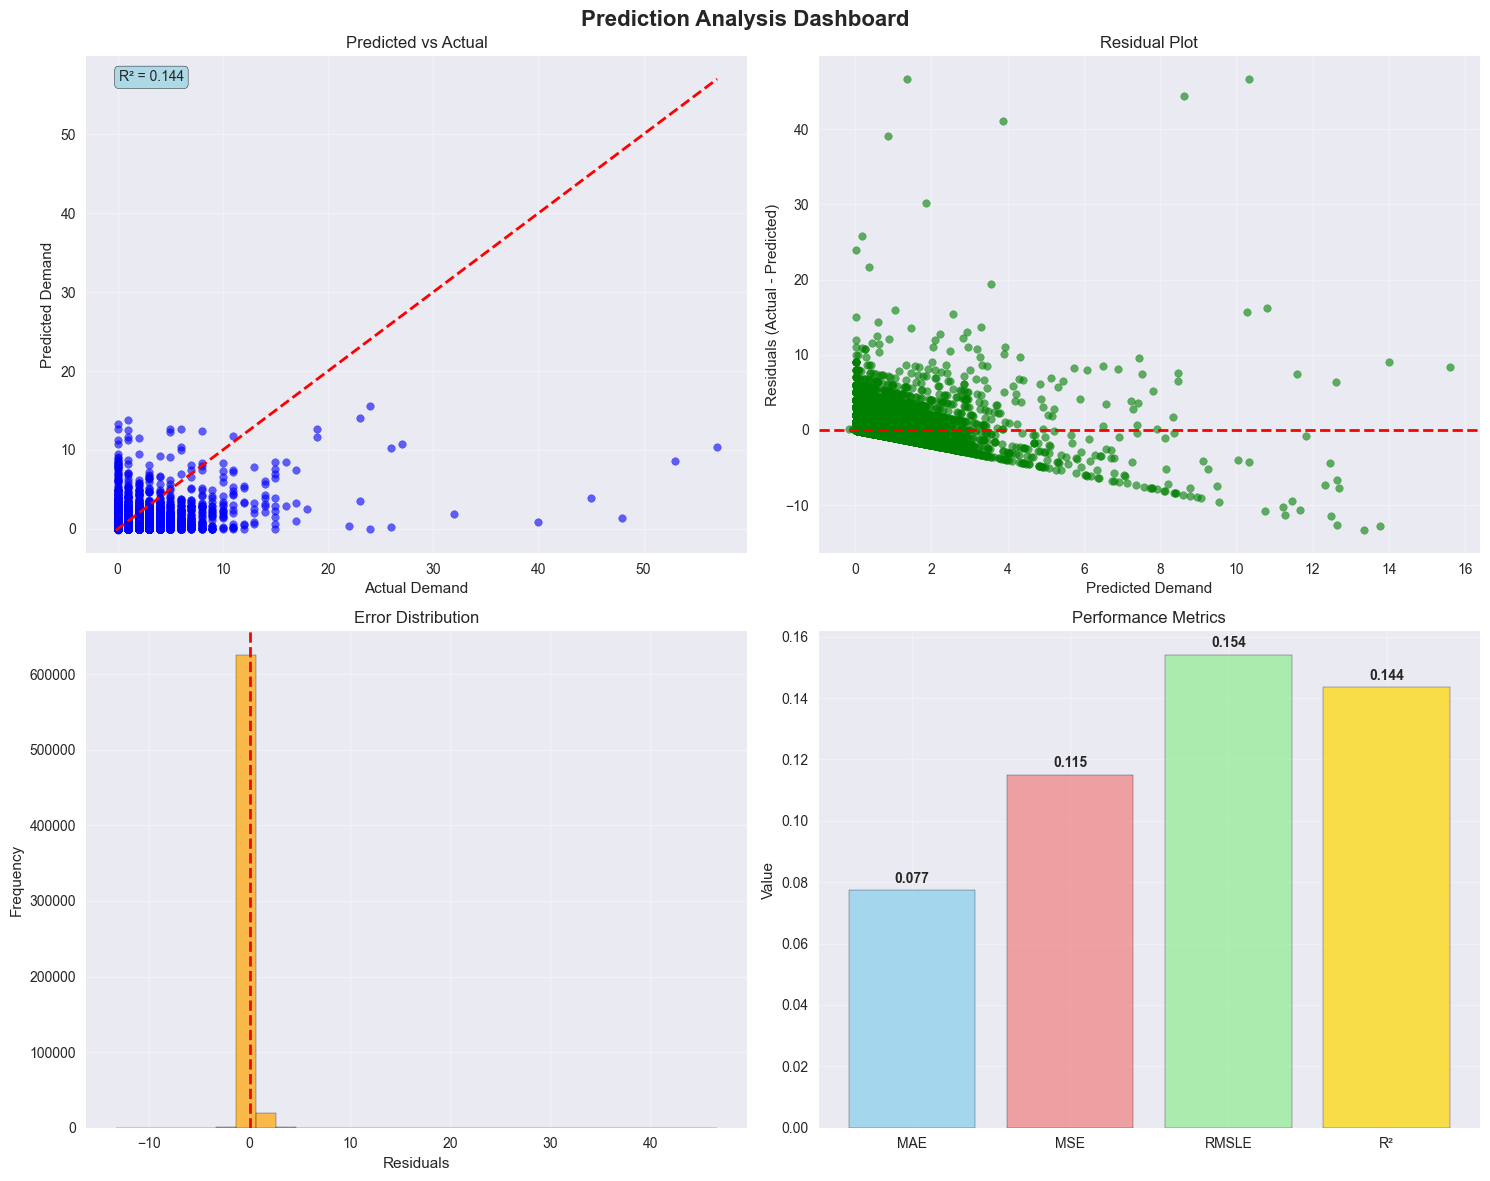

In [16]:
from model_utils import plot_prediction_dashboard

plot_prediction_dashboard(y_test, y_pred)

# Short Reflexion: Weekly Aggregation Results

#### Performance Improvement Analysis ####

- **R² improvement:** 3.8% → 13.1% (3.4x better)
- **Sparsity reduction:** Daily → Weekly aggregation successfully reduced the some of zero problem
- **Still insufficient:**  13.1% R² means the model explains only 13% of demand variation


#### Why Performance Remains Poor ####
- **Inherent Demand Volatility:** E-commerce demand is naturally intermittent and hard to predict
- **Product-level Granularity:** Individual products have erratic patterns; category-level might work better

#### Recommendations ####
- **Try Category-Level Forecasting**
